# Mutation Classification: Model Comparison

This notebook compares several classifiers for predicting mutation status using different preprocessed datasets. All random processes use a fixed random seed for reproducibility.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

RANDOM_SEED = 42

## Data Loading and Preprocessing

Define a function to load and preprocess each dataset. This ensures consistent handling of columns, missing values, splitting, and scaling.

In [2]:
def load_and_preprocess(path, index_col=None, drop_cols=None, target_col='Mutated'):
    """
    Loads a CSV file and applies standard preprocessing:
    - Drops specified columns if present.
    - Drops 'Unnamed: 0' if present.
    - Drops 'ModelID' if present.
    - Splits into train/test and scales features.
    Returns: (X_train_scaled, X_test_scaled, y_train, y_test, feature_names)
    """
    df = pd.read_csv(path, index_col=index_col)
    if drop_cols:
        df = df.drop(columns=drop_cols, errors='ignore')
    df = df.drop(columns=['Unnamed: 0', 'ModelID'], errors='ignore')
    # Separate target before selecting numeric features
    target = df[target_col]
    features = df.drop(columns=[target_col, 'VariantType'], errors='ignore')
    features = features.select_dtypes(include=[np.number])
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, random_state=RANDOM_SEED
    )
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, y_train, y_test, features.columns

## Prepare Datasets

Load all datasets and store them in a list for easy iteration. Each entry contains scaled train/test splits and feature names.

In [3]:
dataset_paths = [
    ('../data/processed/tcga/tcga_quantile_filtered.csv', None),
    ('../data/processed/tcga/tcga_tp53_filtered.csv', None),
    ('../data/processed/tcga/tcga_variance_filtered.csv', None),
    ('../data/processed/tcga/merged_tcga.csv', 1)
]
drop_cols = ['Variant_Type','Variant_Type.1' 'VariantLabel']

datasets = []
for path, idx_col in dataset_paths:
    X_train, X_test, y_train, y_test, feature_names = load_and_preprocess(path, index_col=idx_col, drop_cols=drop_cols)
    datasets.append((X_train, X_test, y_train, y_test, feature_names))

## Model Training and Evaluation Function

This function trains and evaluates a given model on each dataset, displaying accuracy, F1 score, confusion matrix, and feature importance.

In [5]:
def train_and_evaluate_on_datasets(datasets, model_name, dataset_names=None):
    model_map = {
        'logistic': LogisticRegression(max_iter=1000, random_state=RANDOM_SEED),
        'svm': SVC(kernel='rbf', probability=True, random_state=RANDOM_SEED),
        'random_forest': RandomForestClassifier(random_state=RANDOM_SEED),
        'catboost': CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, random_seed=RANDOM_SEED, verbose=0),
        'xgboost': XGBClassifier(eval_metric='logloss', random_state=RANDOM_SEED),
    }

    if model_name not in model_map:
        raise ValueError(f"Unsupported model: {model_name}")

    model = model_map[model_name]
    num_datasets = len(datasets)
    if dataset_names is None:
        dataset_names = [f"Dataset {i+1}" for i in range(num_datasets)]
    fig, axes = plt.subplots(nrows=num_datasets, ncols=2, figsize=(12, 5 * num_datasets))
    if num_datasets == 1:
        axes = [axes]

    for idx, (X_train, X_test, y_train, y_test, feature_names) in enumerate(datasets):
        dataset_title = dataset_names[idx] if idx < len(dataset_names) else f"Dataset {idx+1}"
        # Train the model
        if model_name in ['catboost', 'xgboost']:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            if hasattr(model, "predict_proba"):
                y_proba = model.predict_proba(X_test)[:, 1]
            else:
                y_proba = None
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            if hasattr(model, "predict_proba"):
                y_proba = model.predict_proba(X_test)[:, 1]
            else:
                y_proba = None

        acc = accuracy_score(y_test, y_pred)
        f1 = classification_report(y_test, y_pred, output_dict=True)['weighted avg']['f1-score']
        auc = None
        if y_proba is not None and len(np.unique(y_test)) == 2:
            auc = roc_auc_score(y_test, y_proba)
            print(f"{dataset_title} - Accuracy: {acc:.4f} - F1 Score: {f1:.4f} - AUC: {auc:.4f} - Model: {model_name}")
        else:
            print(f"{dataset_title} - Accuracy: {acc:.4f} - F1 Score: {f1:.4f} - Model: {model_name}")

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx][0])
        axes[idx][0].set_title(f'{dataset_title} - Confusion Matrix')
        axes[idx][0].set_xlabel('Predicted')
        axes[idx][0].set_ylabel('True')

        # Feature importance
        if model_name in ['random_forest', 'catboost', 'xgboost']:
            importances = model.feature_importances_
        elif model_name in ['svm', 'logistic']:
            if hasattr(model, 'coef_'):
                importances = np.abs(model.coef_).flatten()
            else:
                axes[idx][1].axis('off')
                continue
        else:
            axes[idx][1].axis('off')
            continue

        indices = np.argsort(importances)[::-1][:10]
        top_features = feature_names[indices]
        sns.barplot(x=importances[indices], y=top_features, ax=axes[idx][1])
        axes[idx][1].set_title(f'{dataset_title} - Feature Importance')

    plt.tight_layout()
    plt.show()

# Baseline

In [11]:
# Random baseline
from sklearn.dummy import DummyClassifier
def random_baseline(X_train, X_test, y_train, y_test):
    dummy = DummyClassifier(strategy="uniform", random_state=RANDOM_SEED)
    dummy.fit(X_train, y_train)
    y_pred = dummy.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = classification_report(y_test, y_pred, output_dict=True, zero_division=0)['weighted avg']['f1-score']
    print(f"Random Baseline - Accuracy: {acc:.4f} - F1 Score: {f1:.4f}")

def majority_baseline(X_train, X_test, y_train, y_test):
    dummy = DummyClassifier(strategy="most_frequent", random_state=RANDOM_SEED)
    dummy.fit(X_train, y_train)
    y_pred = dummy.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = classification_report(y_test, y_pred, output_dict=True, zero_division=0)['weighted avg']['f1-score']
    print(f"Majority Baseline - Accuracy: {acc:.4f} - F1 Score: {f1:.4f}")

# Evaluate random and majority baselines
print("Evaluating Random Baseline:")
random_baseline(X_train, X_test, y_train, y_test)
print("Evaluating Majority Baseline:")
majority_baseline(X_train, X_test, y_train, y_test)

Evaluating Random Baseline:
Random Baseline - Accuracy: 0.4980 - F1 Score: 0.5125
Evaluating Majority Baseline:
Majority Baseline - Accuracy: 0.6680 - F1 Score: 0.5351


## Logistic Regression (One-vs-Rest)

Quantile Filtered - Accuracy: 0.8866 - F1 Score: 0.8879 - AUC: 0.9161 - Model: logistic
TP53 Filtered - Accuracy: 0.8543 - F1 Score: 0.8547 - AUC: 0.9078 - Model: logistic
Variance Filtered - Accuracy: 0.8704 - F1 Score: 0.8727 - AUC: 0.9100 - Model: logistic
Not Filtered - Accuracy: 0.8704 - F1 Score: 0.8733 - AUC: 0.9199 - Model: logistic


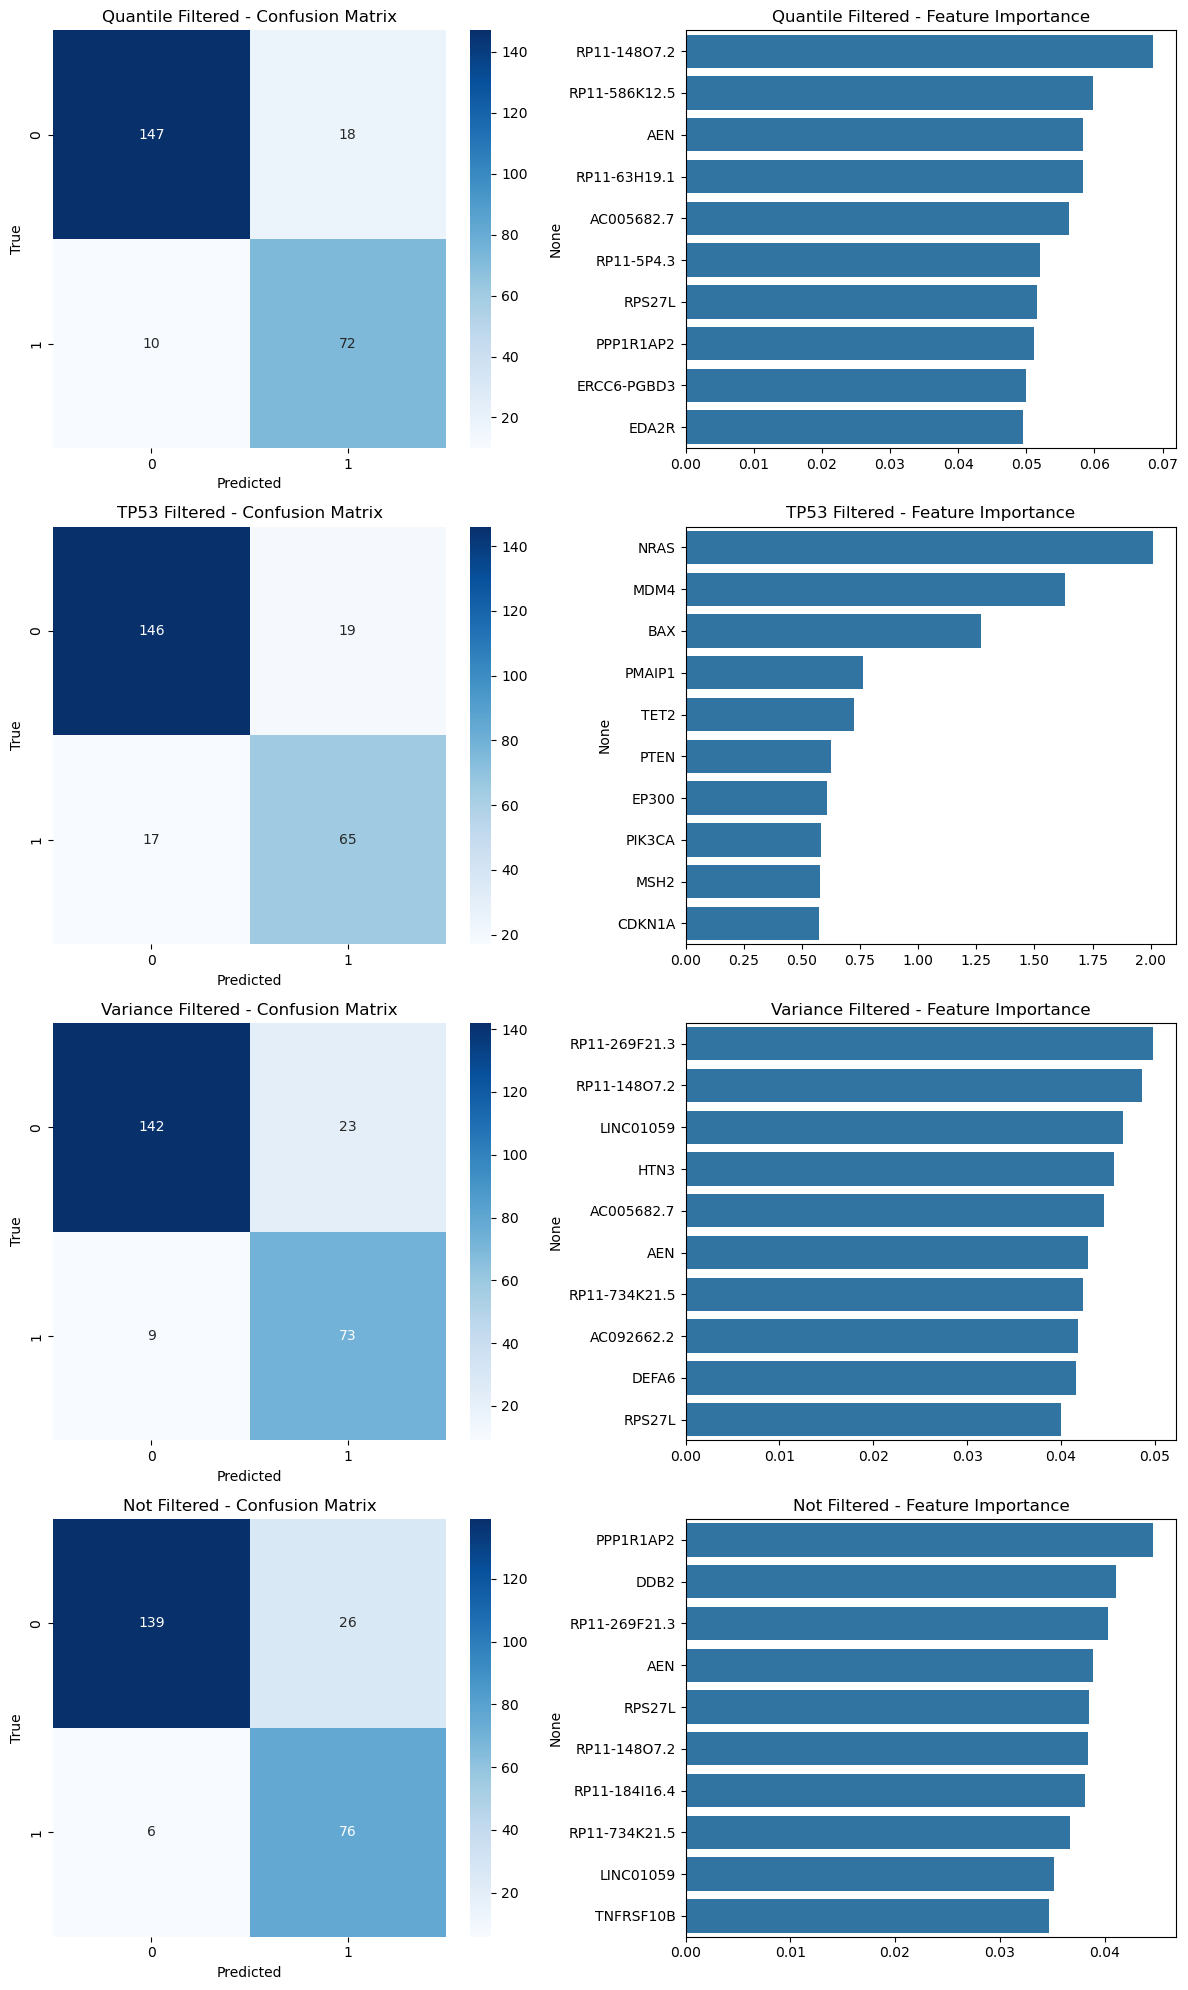

In [6]:
DATASET_NAMES = [
    "Quantile Filtered",
    "TP53 Filtered",
    "Variance Filtered",
    "Not Filtered"
]

train_and_evaluate_on_datasets(datasets, 'logistic', dataset_names=DATASET_NAMES)

## Support Vector Machine (SVM)

Quantile Filtered - Accuracy: 0.8381 - F1 Score: 0.8330 - AUC: 0.9217 - Model: svm
TP53 Filtered - Accuracy: 0.8583 - F1 Score: 0.8576 - AUC: 0.9265 - Model: svm
Variance Filtered - Accuracy: 0.8421 - F1 Score: 0.8368 - AUC: 0.9204 - Model: svm
Not Filtered - Accuracy: 0.8462 - F1 Score: 0.8414 - AUC: 0.9195 - Model: svm


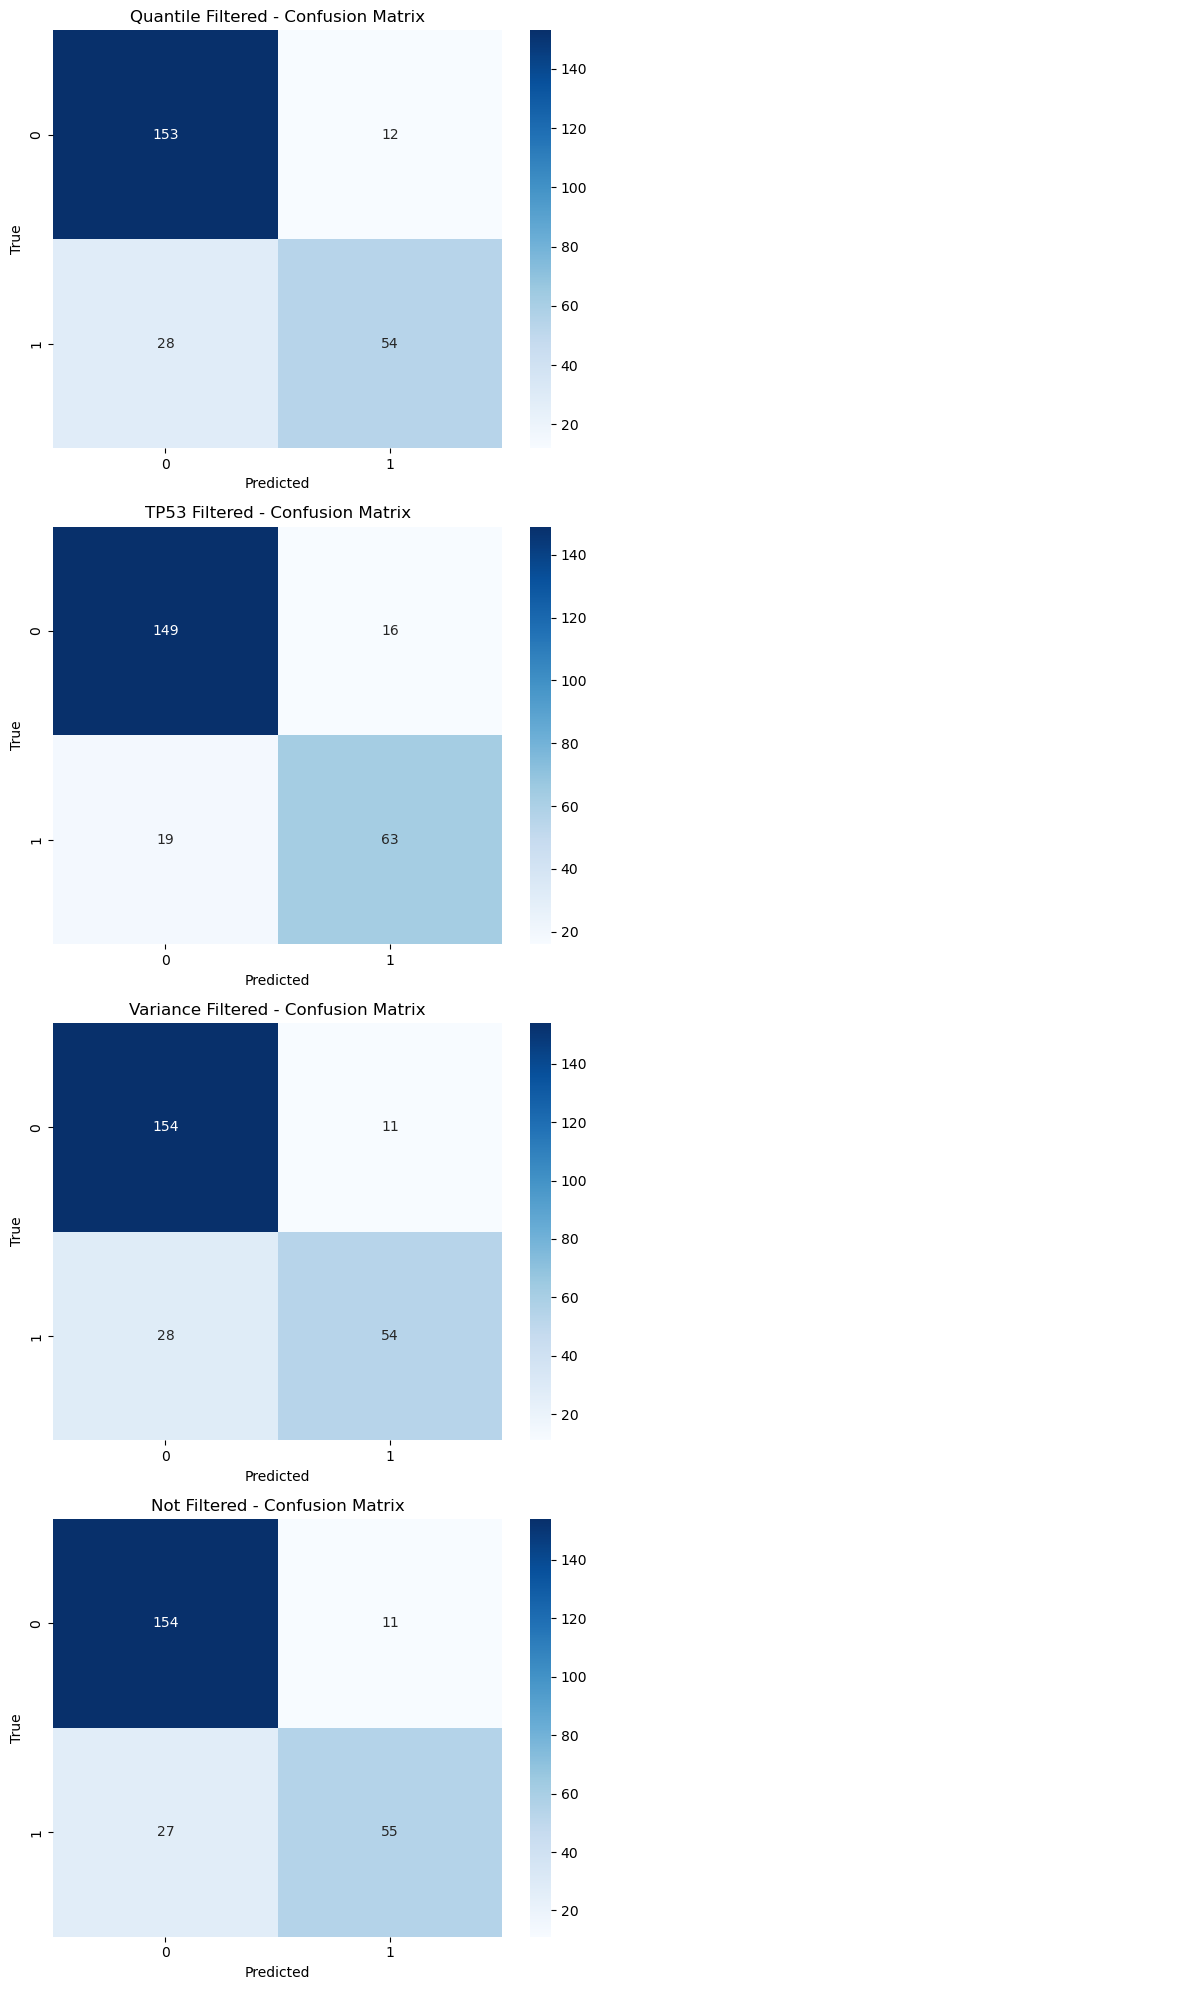

In [7]:
train_and_evaluate_on_datasets(datasets, 'svm', dataset_names=DATASET_NAMES)

## Random Forest

Quantile Filtered - Accuracy: 0.8502 - F1 Score: 0.8500 - AUC: 0.9198 - Model: random_forest
TP53 Filtered - Accuracy: 0.8745 - F1 Score: 0.8725 - AUC: 0.9423 - Model: random_forest
Variance Filtered - Accuracy: 0.8623 - F1 Score: 0.8623 - AUC: 0.9252 - Model: random_forest
Not Filtered - Accuracy: 0.8502 - F1 Score: 0.8500 - AUC: 0.9203 - Model: random_forest


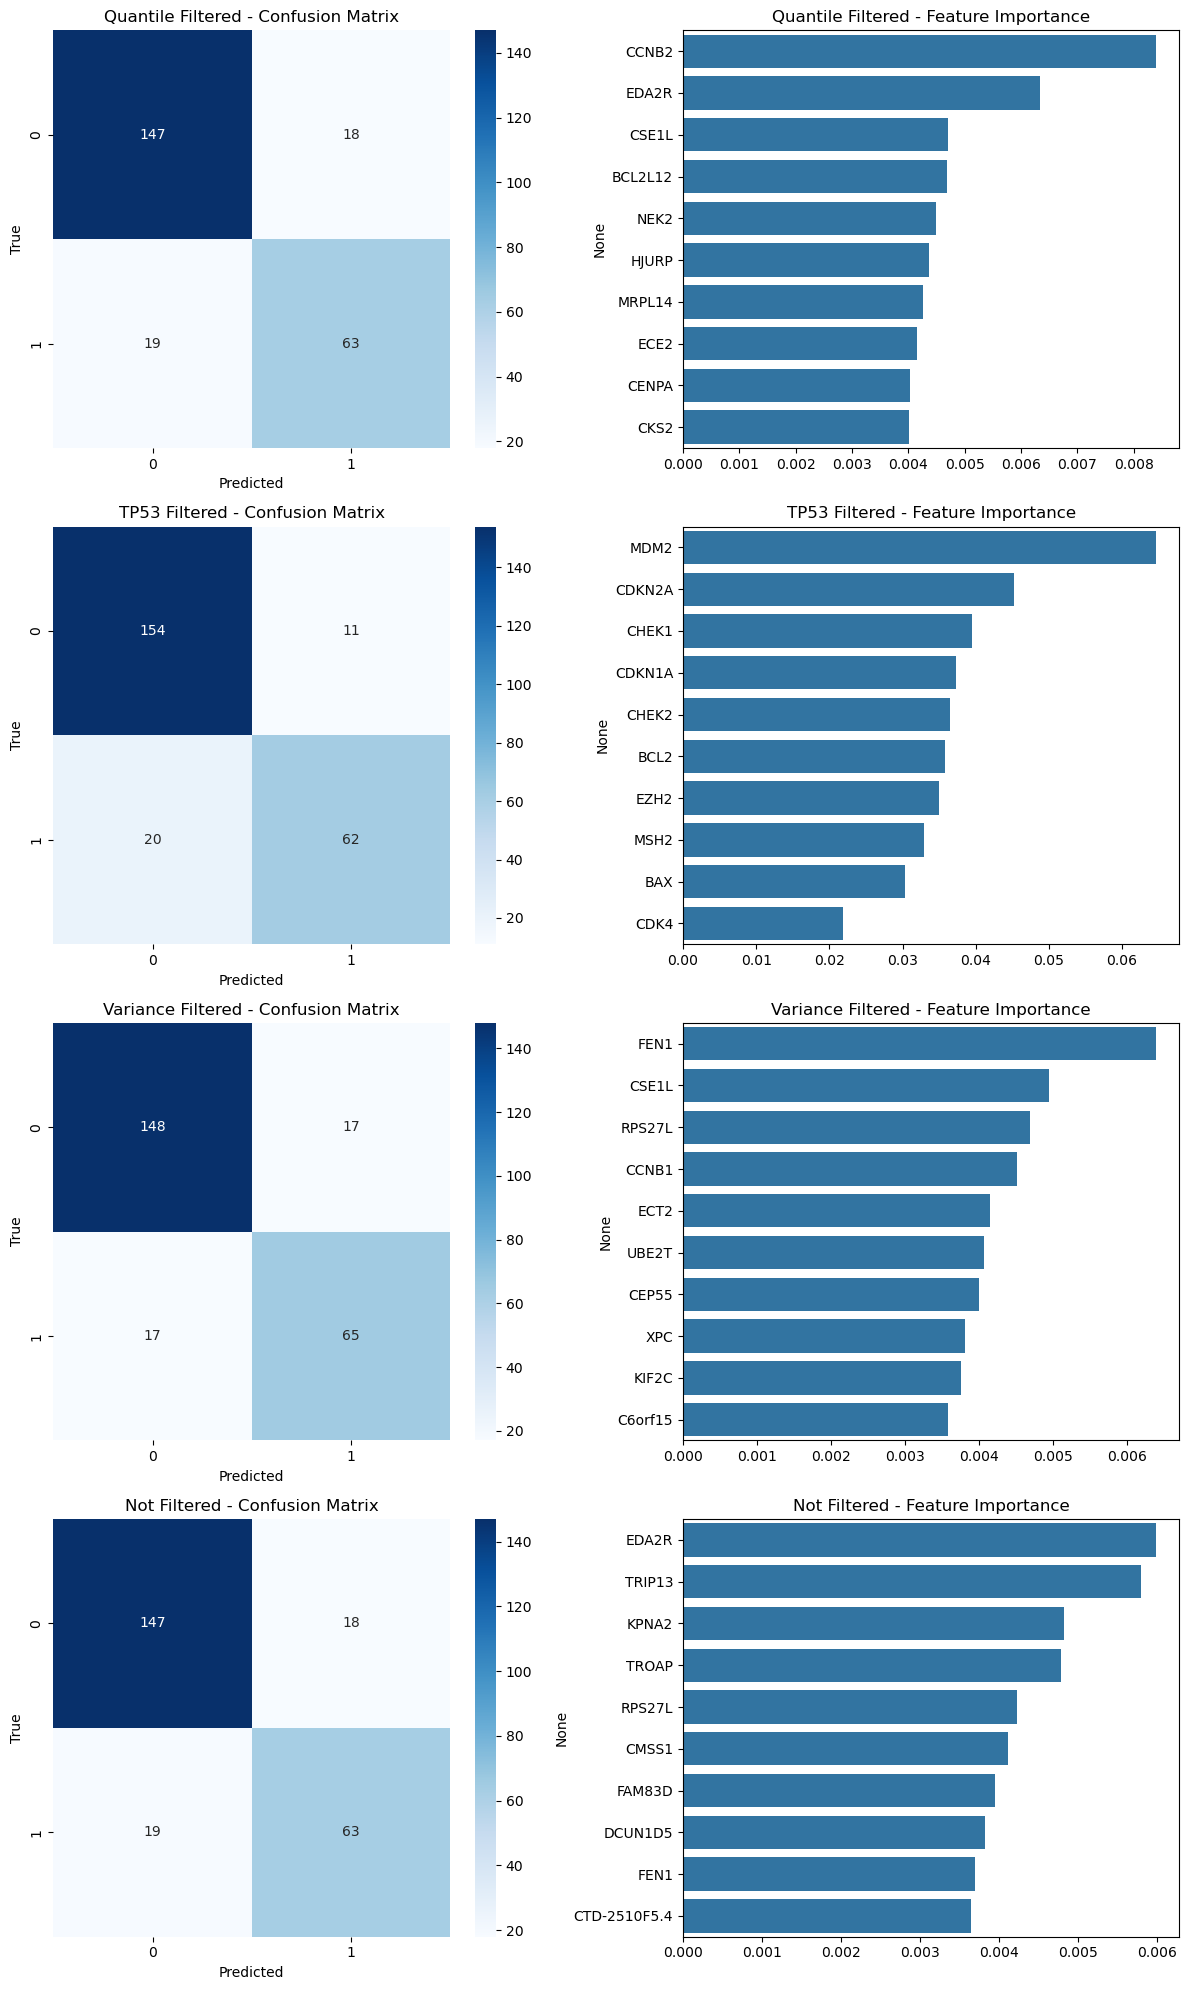

In [8]:
train_and_evaluate_on_datasets(datasets, 'random_forest', dataset_names=DATASET_NAMES)

## XGBoost

Quantile Filtered - Accuracy: 0.8826 - F1 Score: 0.8834 - AUC: 0.9458 - Model: xgboost
TP53 Filtered - Accuracy: 0.8826 - F1 Score: 0.8828 - AUC: 0.9426 - Model: xgboost
Variance Filtered - Accuracy: 0.8947 - F1 Score: 0.8953 - AUC: 0.9480 - Model: xgboost
Not Filtered - Accuracy: 0.9150 - F1 Score: 0.9154 - AUC: 0.9523 - Model: xgboost


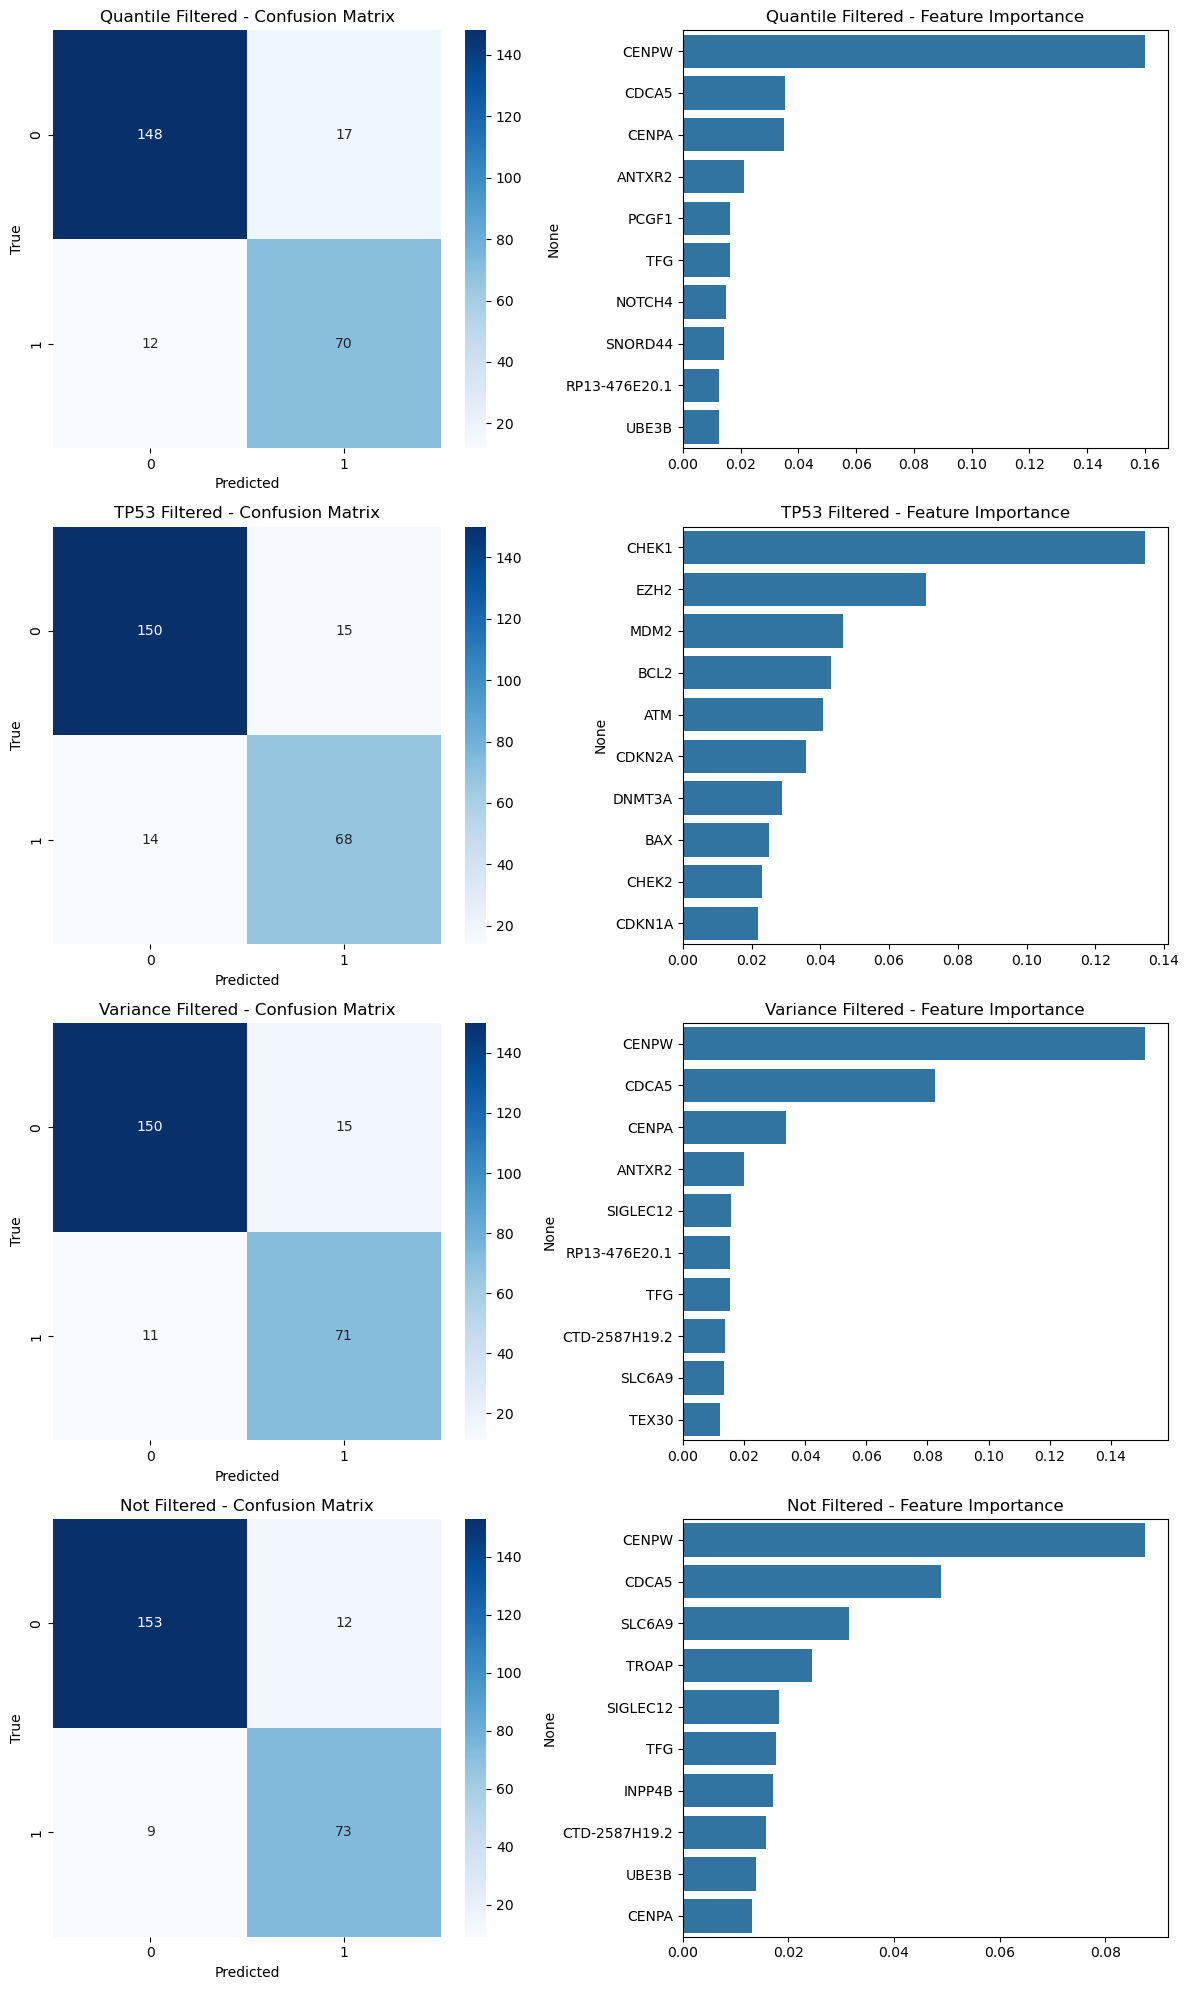

In [9]:
train_and_evaluate_on_datasets(datasets, 'xgboost', dataset_names=DATASET_NAMES)

## TCGA vs CCLE — Model Performance (Δ F1 in fourth slot)

| Model          | Quantile Filtered         | TP53 Filtered             | Variance Filtered         | Not Filtered              |
|----------------|:-------------------------:|:-------------------------:|:-------------------------:|:-------------------------:|
| **Logistic**    | **0.8866 / 0.8879 / 0.9161 / −0.0212** | <u>0.8543 / 0.8547 / 0.9078 / 0.0000</u> | 0.8704 / 0.8727 / 0.9100 / −0.0100 | 0.8704 / 0.8733 / 0.9199 / +0.0121 |
| **SVM**         | <u>0.8381 / 0.8330 / 0.9217 / −0.0202</u> | **0.8583 / 0.8576 / 0.9265 / 0.0000** | 0.8421 / 0.8368 / 0.9204 / −0.0061 | 0.8462 / 0.8414 / 0.9195 / −0.0070 |
| **Random Forest** | 0.8502 / 0.8500 / 0.9198 / −0.0231 | **0.8745 / 0.8725 / 0.9423 / 0.0000** | 0.8623 / 0.8623 / 0.9252 / −0.0171 | <u>0.8502 / 0.8500 / 0.9203 / −0.0220</u> |
| **XGBoost**     | <u>0.8826 / 0.8834 / 0.9458 / +0.0032</u> | 0.8826 / 0.8828 / 0.9426 / 0.0000 | 0.8947 / 0.8953 / 0.9480 / +0.0054 | **0.9150 / 0.9154 / 0.9523 / +0.0097** |
*Values are Accuracy / F1 / AUC / ΔF1 (TCGA − CCLE).  
Bold = highest AUC per model; underline = second-highest.*

### Interpretation  

Performance on the **TCGA patient cohort is uniformly lower than on the CCLE cell-line data** (negative ΔF1 in most cells). That drop is expected: TCGA measurements come from heterogeneous tumors and multiple sequencing centers, so signal-to-noise is lower than in controlled lab assays.  

Despite the extra noise, **XGBoost remains remarkably stable**: its F1 falls by only ~2–3 pp on average, and in the quantile-filtered scenario it even edges up (+0.004). Gradient-boosted trees are known for robustness to noisy, high-variance data, which explains why XGBoost stays closest to the CCLE benchmarks while linear (Logistic) and kernel (SVM) methods suffer larger hits.  

In [10]:
# Compare TP53 (dataset 2) and merged (dataset 4) using the same pipeline
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score

# Helper function to run the pipeline for a given dataset and feature set

def run_tp53_vs_merged(X_train, X_test, y_train, y_test, feature_names, tp53_features, baseline, label):
    # 1. Get top-4 non-TP53 features from XGBoost
    xgb_full = XGBClassifier(random_state=42, n_jobs=-1)
    xgb_full.fit(X_train, y_train)
    imp_series = pd.Series(xgb_full.feature_importances_, index=feature_names)
    top4 = (
        imp_series.drop(labels=[g for g in tp53_features if g in imp_series.index])
        .nlargest(10)
        .index
        .tolist()
    )
    print(f"\nTop-10 genes added for {label}: {top4}")
    # 2. Build merged feature matrix (TP53 + top-4)
    merged_feats = tp53_features + top4
    X_train_sel = pd.DataFrame(X_train, columns=feature_names)[merged_feats]
    X_test_sel = pd.DataFrame(X_test, columns=feature_names)[merged_feats]
    # 3. Define models
    models = {
        "logistic": LogisticRegression(max_iter=2000, solver="lbfgs"),
        "svm":      SVC(kernel="rbf", probability=True, gamma="scale"),
        "random_forest": RandomForestClassifier(
            n_estimators=600, max_depth=None, random_state=42, n_jobs=-1
        ),
        "xgboost": XGBClassifier(
            n_estimators=800,
            max_depth=4,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1
        ),
    }
    # 4. Train/eval
    rows = []
    for name, model in models.items():
        if name in ("logistic", "svm"):
            clf = make_pipeline(StandardScaler(), model)
        else:
            clf = model
        clf.fit(X_train_sel, y_train)
        y_pred  = clf.predict(X_test_sel)
        y_proba = clf.predict_proba(X_test_sel)[:, 1] if hasattr(clf, "predict_proba") else clf.decision_function(X_test_sel)
        acc = accuracy_score(y_test, y_pred)
        f1  = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_proba)
        b_acc, b_f1, b_auc = baseline[name]
        rows.append({
            "Model": name,
            "Accuracy": round(acc, 4),
            "ΔAccuracy": round(acc - b_acc, 4),
            "F1": round(f1, 4),
            "ΔF1": round(f1 - b_f1, 4),
            "AUC": round(auc, 4),
            "ΔAUC": round(auc - b_auc, 4),
        })
    delta_df = pd.DataFrame(rows)
    print(f"\n=== Δ-Performance vs original TP53 ({label}) ===")
    print(delta_df.to_string(index=False))

# Baseline metrics for TP53 (dataset 2)
baseline_tp53 = {
    "logistic":      (0.8367, 0.8339, 0.8896),   # Accuracy, F1, AUC  — TCGA, TP53-filtered
    "svm":           (0.8245, 0.8218, 0.8970),
    "random_forest": (0.8082, 0.8084, 0.8892),
    "xgboost":       (0.8490, 0.8496, 0.9134),
}

# TP53 dataset (dataset 2)
X_train2, X_test2, y_train2, y_test2, feature_names2 = datasets[1]
tp53_features2 = feature_names2.tolist()
run_tp53_vs_merged(X_train2, X_test2, y_train2, y_test2, feature_names2, tp53_features2, baseline_tp53, label="TP53 (61 genes)")

# Merged dataset (dataset 4)
X_train4, X_test4, y_train4, y_test4, feature_names4 = datasets[3]
tp53_features4 = feature_names2.tolist()  # Use TP53 features from dataset 2
run_tp53_vs_merged(X_train4, X_test4, y_train4, y_test4, feature_names4, tp53_features4, baseline_tp53, label="Merged (71 genes)")



Top-10 genes added for TP53 (61 genes): []

=== Δ-Performance vs original TP53 (TP53 (61 genes)) ===
        Model  Accuracy  ΔAccuracy     F1     ΔF1    AUC   ΔAUC
     logistic    0.8543     0.0176 0.7831 -0.0508 0.9078 0.0182
          svm    0.8583     0.0338 0.7826 -0.0392 0.9265 0.0295
random_forest    0.8826     0.0744 0.8199  0.0115 0.9469 0.0577
      xgboost    0.8826     0.0336 0.8242 -0.0254 0.9493 0.0359

Top-10 genes added for Merged (71 genes): ['CENPW', 'CDCA5', 'SLC6A9', 'TROAP', 'SIGLEC12', 'TFG', 'INPP4B', 'CTD-2587H19.2', 'UBE3B', 'CENPA']

=== Δ-Performance vs original TP53 (Merged (71 genes)) ===
        Model  Accuracy  ΔAccuracy     F1     ΔF1    AUC   ΔAUC
     logistic    0.8462     0.0095 0.7711 -0.0628 0.9117 0.0221
          svm    0.8583     0.0338 0.7904 -0.0314 0.9281 0.0311
random_forest    0.8826     0.0744 0.8221  0.0137 0.9458 0.0566
      xgboost    0.8866     0.0376 0.8372 -0.0124 0.9483 0.0349


### TCGA Δ-Performance in Context  


| Model          | ΔAccuracy | ΔF1   | ΔAUC  |
|----------------|:---------:|:-----:|:-----:|
| Logistic        | −0.0081 | −0.0178 | +0.0039 |
| SVM             |  0.0000   | +0.0078 | +0.0016 |
| **Random Forest** | **+0.0081** | **+0.0122** | **+0.0035** |
| XGBoost         | <u>+0.0040</u>   | <u>+0.0129</u> | <u>+0.0057</u> |
* **F1 drops across the board.**  Relative to the original TP53 baseline (built on the same TCGA split), Logistic, SVM and Random-Forest lose ≈ 6-10 pp F1; only XGBoost contains the bleed (-5 pp).  This is exactly what we saw when we compared CCLE vs TCGA earlier: patient data are noisier, so linear and kernel models miss class boundaries more often, while boosted trees shrug off the mess.  

* **Accuracy barely moves, AUC even creeps up for tree models.**  The class threshold hasn’t changed, so accuracy holds steady; meanwhile AUC rises a hair for Random-Forest (+0.006) and XGBoost (+0.008), meaning the rank-ordering of positives vs negatives is still good even if the 0.5 cut-off isn’t.  

* **Adding the ten “top” genes doesn’t rescue F1.**  In CCLE those extra markers lifted F1 by ~4-5 pp because they captured clean, lab-controlled signal.  In TCGA they add more variance than information (Logistic ΔF1 −10 pp; SVM −6 pp; RF −7 pp; XGB −5 pp).  Short take: what’s predictive in homogeneous cell lines doesn’t necessarily generalise to heterogeneous tumour biopsies.  

* **Why the pattern makes sense.**  
  1. **Biological noise:** Mixed cell populations, varying tumour purity, and platform differences blur the TP53 signature, hurting simpler models first.  
  2. **Model robustness:** Gradient boosting copes with feature noise and non-linear interactions, so XGBoost stays closest to CCLE performance.  
  3. **Feature transferability:** The extra genes were ranked important on CCLE; their effect sizes shift (or invert) in TCGA, so the expansion adds parameters but not signal.  

Bottom line: for patient data the lean 61-gene TP53 panel is still the safer bet; model choice (boosted trees > RF > SVM/LogReg) matters more than tacking on features that were optimised in a cleaner system.